# Real time $R_t$ estimation
This notebook is adapted from the work of Daniele Proverbio - LCSB - 2020-05-09.  

The basic reproduction number [$R_0$](https://en.wikipedia.org/wiki/Basic_reproduction_number) quantifies the potential strength of an epidemic outbreak, at the very beginning of a pandemic. During the epidemic evolution, we can further estimate the time-dependent effective reproduction number [$R_t$](https://www.healthknowledge.org.uk/public-health-textbook/research-methods/1a-epidemiology/epidemic-theory), to have a quantitative probe of its severity. This is also useful for cross-country comparison.  

The algorithm we use is based on [Kevin Systrom's](https://github.com/k-sys/covid-19) - April 17. It is consistent with the one from Mathematical Modelling of Infectious Disases, London School of Hygiene and Tropical Medicine ([link](https://epiforecasts.io/covid/contributors.html)). Here, we adapted it for Indonesia, with updated stream flow for estimation and plotting. Given the latest literature, [serial interval](https://en.wikipedia.org/wiki/Serial_interval) for COVID-19 is [about 7 days](https://www.jwatch.org/na51171/2020/03/27/serial-interval-covid-19). 


In [1]:
# preliminary setting

import pandas as pd
import numpy as np
import datetime as DT
import requests
import json

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

#-----

state_name = 'Jakarta'
state_name_idn = 'DKI_JAKARTA' #use CAPS and underscore as space, e.g West Java = JAWA_BARAT
today = DT.datetime.now().strftime("%Y%m%d")

## Smoothing the Data

Case reporting is very erratic based on testing backlogs, etc. To get the best view of the 'true' data we can, I've applied a gaussian filter to the time series. This is obviously an arbitrary choice, but you'd imagine the real world process is not nearly as stochastic as the actual reporting.

In [2]:
# prepare data, to get daily cases and smoothing
def prepare_cases(cases, cutoff=22):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,    #7 days moving window for smoothing
        win_type='gaussian',   #or comment whole line to have uniform
        min_periods=1,
        center=True).mean(std=2).round()
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed


## Bettencourt & Ribeiro's Approach

Every day, we learn how many more people have COVID-19. This new case count gives us a clue about the current value of $R_t$. We also, figure that the value of $R_t$ today is related to the value of $R_{t-1}$ (yesterday's value) and every previous value of $R_{t-m}$ for that matter.

With these insights, the authors use [Bayes' rule](https://en.wikipedia.org/wiki/Bayes%27_theorem) to update their beliefs about the true value of $R_t$ based on how many new cases have been reported each day.

This is Bayes' Theorem as we'll use it:

$$ P(R_t|k)=\frac{P(k|R_t)\cdot P(R_t)}{P(k)} $$

This says that, having seen $k$ new cases, we believe the distribution of $R_t$ is equal to:

- The __likelihood__ of seeing $k$ new cases given $R_t$ times ...
- The __prior__ beliefs of the value of $P(R_t)$ without the data ...
- divided by the probability of seeing this many cases in general.

This is for a single day. To make it iterative: every day that passes, we use yesterday's prior $P(R_{t-1})$ to estimate today's prior $P(R_t)$. 

### Distribution of P ($R_t$)

We will assume the distribution of $R_t$ to be a Gaussian centered around $R_{t-1}$, so:

$$P(R_t|R_{t-1})=\mathcal{N}(R_{t-1}, \sigma)$$, where $\sigma$ is a hyperparameter. 

So on day one:

$$ P(R_1|k_1) \propto P(R_1)\cdot \mathcal{L}(R_1|k_1)$$

On day two:

$$ P(R_2|k_1,k_2) \propto P(R_2)\cdot \mathcal{L}(R_2|k_2) = \sum_{R_1} {P(R_1|k_1)\cdot P(R_2|R_1)\cdot\mathcal{L}(R_2|k_2) }$$

etc.

### Choosing a Likelihood Function $P\left(k_t|R_t\right)$

A likelihood function function says how likely we are to see $k$ new cases, given a value of $R_t$.

Any time you need to model 'arrivals' over some time period of time, statisticians like to use the [Poisson Distribution](https://en.wikipedia.org/wiki/Poisson_distribution). Given an average arrival rate of $\lambda$ new cases per day, the probability of seeing $k$ new cases is distributed according to the Poisson distribution:

$$P(k|\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$

The Poisson distribution says that if you think you're going to have $\lambda$ cases per day, you'll probably get that many, plus or minus some variation based on chance.

But in our case, we know there have been $k$ cases and we need to know what value of $\lambda$ is most likely. In order to do this, we fix $k$ in place while varying $\lambda$. __This is called the likelihood function.__


For example, imagine we observe  𝑘=20  new cases, and we want to know how likely each  𝜆  is:

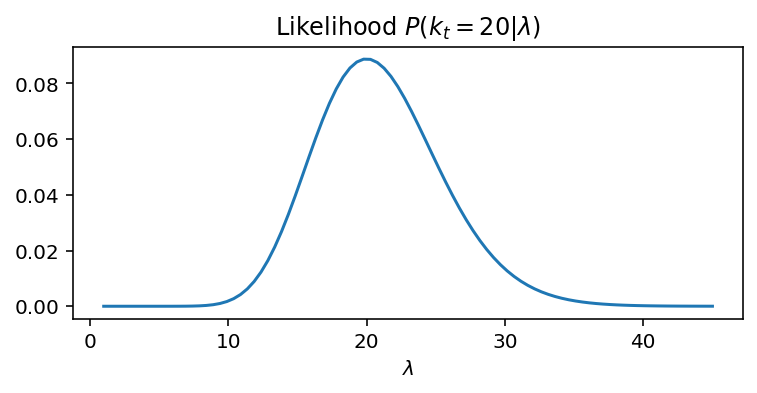

In [3]:
k = 20

lam = np.linspace(1, 45, 90)

likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=r'Likelihood $P\left(k_t=20|\lambda\right)$', figsize=(6,2.5));

This says that if we see 20 cases, the most likely value of $\lambda$ is (not surprisingly) 20. But we're not certain: it's possible lambda was 21 or 17 and saw 20 new cases by chance alone. It also says that it's unlikely $\lambda$ was 40 and we saw 20.

Great. We have $P\left(\lambda_t|k_t\right)$ which is parameterized by $\lambda$ but we were looking for $P\left(k_t|R_t\right)$ which is parameterized by $R_t$. We need to know the relationship between $\lambda$ and $R_t$

### Connecting $\lambda$ and $R_t$

__The key insight to making this work is to realize there's a connection between $R_t$ and $\lambda$__. [The derivation](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) is beyond the scope of this notebook, but here it is:

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

where $\gamma$ is the reciprocal of the serial interval ([about 7 days for COVID19](https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article)). Since we know every new case count on the previous day, we can now reformulate the likelihood function as a Poisson parameterized by fixing $k$ and varying $R_t$.

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

$$P\left(k|R_t\right) = \frac{\lambda^k e^{-\lambda}}{k!}$$



### Function for Calculating the Posteriors $P(R_t|k)$ 

To calculate the posteriors, $P(R_t|k)$ , we follow these steps:

1. Calculate $\lambda$ - the expected arrival rate for every day's poisson process

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

2. Calculate each day's likelihood distribution over all possible values of $R_t$

$$P\left(k|R_t\right) = \frac{\lambda^k e^{-\lambda}}{k!}$$

3. Calculate the process matrix based on the value of $\sigma$ = 0.06 (you can change this)

4. Calculate our initial prior, P(R_t0) because our first day does not have a previous day from which to take the posterior

$P(R_t|R_{t-1})=\mathcal{N}(R_{t-1}, \sigma)$, where $\sigma$ is a hyperparameter. 

  - Based on [info from the cdc](https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article) we will choose a Gamma with mean 7.

5. Loop from day 1 to the end, doing the following:
  - Calculate the prior by applying the Gaussian to yesterday's prior.
  - Apply Bayes' rule by multiplying this prior and the likelihood we calculated in step 2.
  - Divide by the probability of the data (also Bayes' rule)

In [4]:
# getting posteriors for R_t evaluation
def get_posteriors(sr, date, sigma=0.06):

    # (1) Calculate Lambda
    #gamma=1/np.random.normal(7, 0.00001, len(r_t_range))
    #lam = sr[:-1] * np.exp(gamma[:, None] * (r_t_range[:, None] - 1))
    GAMMA = 1/7
    lam = sr[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))
    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:], lam),
        index = r_t_range,
        columns = date[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    #prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=date,
        data={date[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(date[:-1], date[1:]):

        #(5a) Calculate the new prior, P(R_t)
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

#----

# getting highest density intervals for Rt

def highest_density_interval(pmf, p=.9, debug=False):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])



# Plugging in data from the Covid19.go.id website

In [5]:
data = 'https://data.covid19.go.id/public/api/prov_detail_'+state_name_idn+'.json'
response = requests.get(data)
jkt_data = json.loads(response.text)
json_string = json.dumps(jkt_data['list_perkembangan'])
df_jktdata = pd.read_json(json_string)
df_jktdata['date'] = pd.to_datetime(df_jktdata['tanggal']/1000, unit='s')
total_cases = df_jktdata['AKUMULASI_KASUS'].values
jkt_cases = pd.Series(total_cases, index=df_jktdata['date'])

## Preparing data for analysis

In [6]:
# Prepare data for analysis - getting the smoothed value

cases = jkt_cases
original, smoothed = prepare_cases(cases)

#convert into array for easier handling
#original_array = original.values
#smoothed_array = smoothed.values
original_array = original.values
smoothed_array = smoothed.values

# dates: what we have in real time are detected of cases, but they refer to infection happened several days ago
# comparing with Nowcasting procedures, this latancy is 8±1 days
dates = smoothed.index
dates_detection = date2num(smoothed.index.tolist())
dates_infection = smoothed.index - DT.timedelta(days=9)
dates_infection = date2num(dates_infection.tolist())

In [7]:
#estimate R_t (for detection) and print 

R_T_MAX = 10
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

posteriors, log_likelihood = get_posteriors(smoothed_array, dates, sigma=0.06)    #optimal sigma already chosen in original Notebook

# Note that this is not the most efficient algorithm, but works fine
hdis = highest_density_interval(posteriors, p=.9)          # confidence bounds, p=90%

most_likely = posteriors.idxmax().rename('R_t-estimate')   #mean R_t value

result = pd.concat([most_likely, hdis], axis=1)            #global result for R_t-estimate
print(result.tail())
print(result.head())

#result.to_csv('/Users/daniele.proverbio/python-workspace/PhD/covid-19/R_t/R_t-estimation/plots_results/simulation_DanieleProverbio_'+today+'_Rt-estimate.csv')
#result.to_csv('simulation_Azman'+state_name+'_'+today+'_Rt-estimate.csv')


            R_t-estimate  Low_90  High_90
date                                     
2020-06-02          0.99    0.65     1.30
2020-06-03          0.97    0.64     1.29
2020-06-04          0.97    0.60     1.26
2020-06-05          0.96    0.60     1.26
2020-06-06          1.00    0.64     1.30
            R_t-estimate  Low_90  High_90
date                                     
2020-03-26          0.00    0.00     9.01
2020-03-27          2.35    0.48     3.92
2020-03-28          1.98    0.65     3.13
2020-03-29          1.68    0.59     2.61
2020-03-30          1.54    0.64     2.38


## Plots

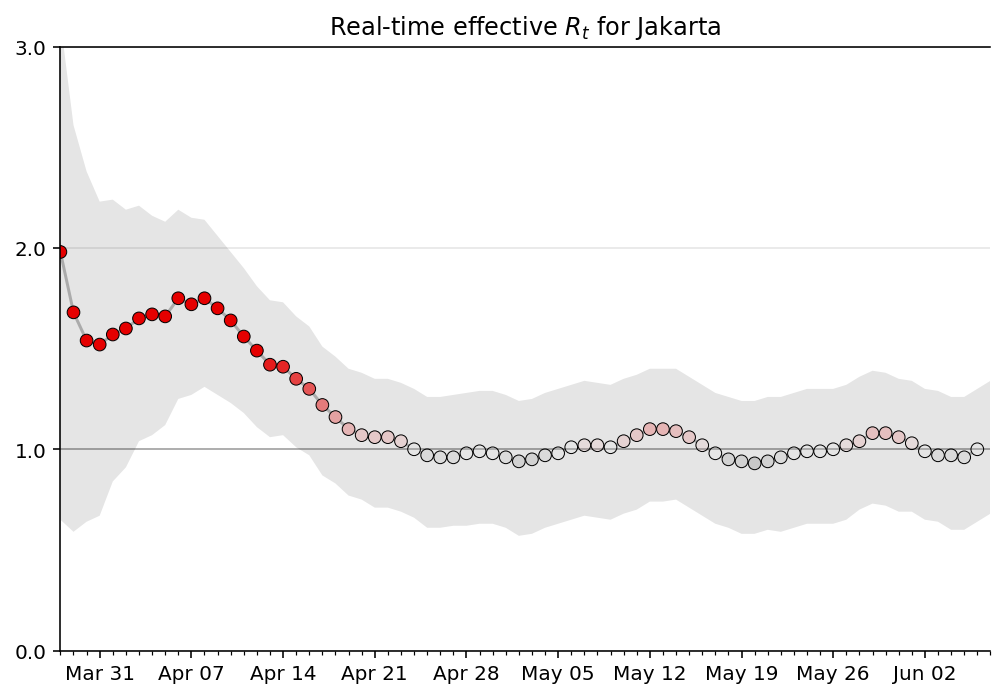

In [8]:
#Plot R_t alone
#Plot only R_t (current)

def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['R_t-estimate'].index.get_level_values('date')
    values = result['R_t-estimate'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.spines['right'].set_visible(False)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 3.0)
    ax.set_xlim(result.index.get_level_values('date')[2], result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax2 = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax2, state_name)
ax2.set_title(f'Real-time effective $R_t$ for {state_name}')
ax2.xaxis.set_major_locator(mdates.WeekdayLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

#fig.savefig("simulation_Azman"+state_name+"_"+today+"_Rt.png",bbox_inches = "tight",transparent=True)


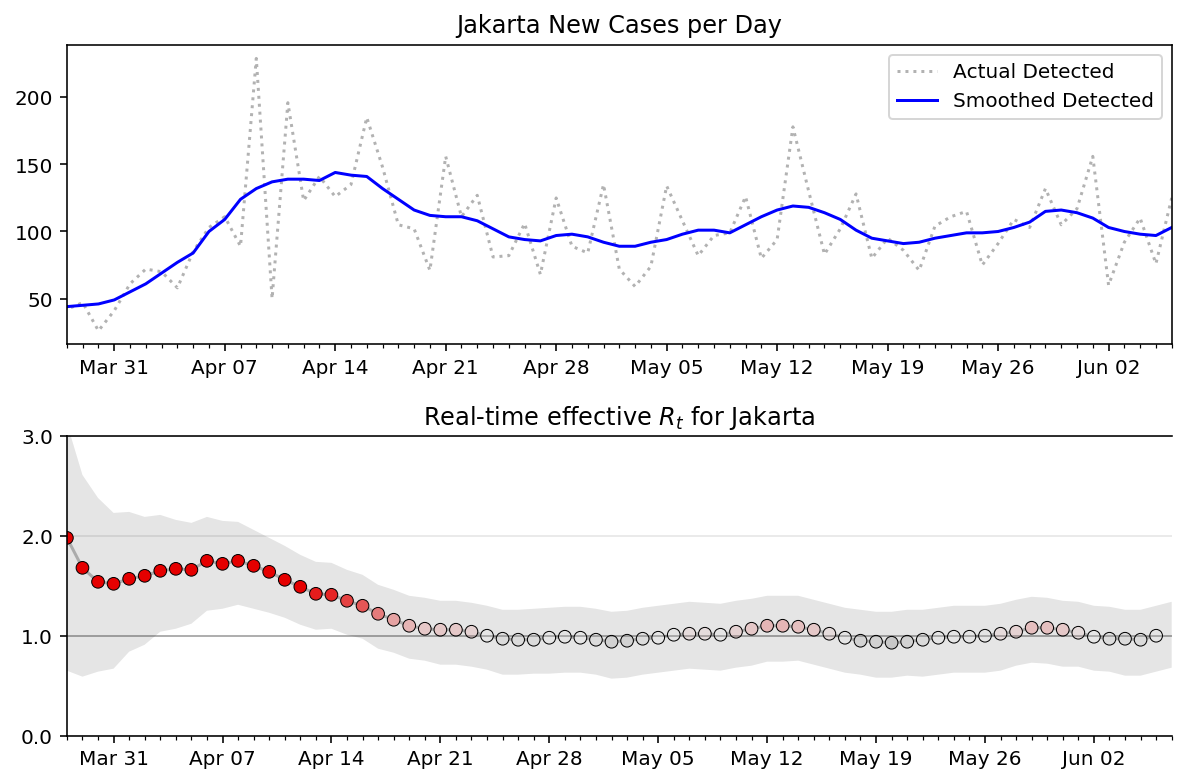

In [9]:
# detected cases, plus R_t

fig, ax = plt.subplots(2,figsize=(600/72,400/72))

#Fig 1
ax[0].set_title(f"{state_name} New Cases per Day")
ax[0].plot_date(dates_detection, original_array,':',alpha=.6,color="grey",label="Actual Detected")
ax[0].plot_date(dates_detection, smoothed_array,'b',label="Smoothed Detected")
#ax[0].plot_date(dates_infection, smoothed_array,'-',color="darkred",label="Smoothed Nowcasted")
ax[0].legend()

ax[0].xaxis.set_major_locator(mdates.WeekdayLocator())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax[0].xaxis.set_minor_locator(mdates.DayLocator())
ax[0].set_xlim(dates_detection[2], dates_detection[-1])


#Fig 2
plot_rt(result, ax[1], state_name)
ax[1].set_title(f'Real-time effective $R_t$ for {state_name}')
ax[1].xaxis.set_major_locator(mdates.WeekdayLocator())
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.tight_layout()

#fig.savefig("simulation_Azman"+state_name+"_"+today+"_both_present.png",bbox_inches = "tight",transparent=True)


In [10]:
result

,R_t-estimate,Low_90,High_90
date,,,
2020-03-26,0.00,0.00,9.01
2020-03-27,2.35,0.48,3.92
2020-03-28,1.98,0.65,3.13
2020-03-29,1.68,0.59,2.61
2020-03-30,1.54,0.64,2.38
...,...,...,...
2020-06-02,0.99,0.65,1.30
2020-06-03,0.97,0.64,1.29
2020-06-04,0.97,0.60,1.26
